In [5]:
import Bio as bio
from Bio import SeqIO
from Bio.Blast.Applications import NcbiblastpCommandline as BlastP
from Bio.Blast import NCBIWWW 
from Bio.Blast import NCBIXML
from Bio import SearchIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import copy
import matplotlib.pyplot as plt
from Bio.SubsMat import MatrixInfo as matlist
file_name = "OphA_wgs_aligned_1361_hits.txt"
protein_sequence_file_name = "OphA_99_NR_hits.txt"

aligned_wgs_sequences_file_name = "OphA_wgs_aligned_eric.txt"
whole_contig_sequences_file_name = "OphA_wgs_whole_contigs_eric.txt"

In [6]:
def get_sequences(file_name): #Returns a list of seqRecords from filename instead of iterable like SeqIO would
    return [seq for seq in SeqIO.parse(file_name,"fasta")]

def translate_sequences(DNA_seq):
    translated_sequences = copy.deepcopy(DNA_seq)
    for i in range(0,len(DNA_seq)):
        if(len(translated_sequences[i].seq)/3 != int(len(translated_sequences[i].seq)/3)):
            print("ERROR, nucleotide sequence not in triplets", translated_sequences[i].name)
            translated_sequences[i].description += " ***likely frameshifted***"
        #else:
            #print("FINE")
        translated_sequences[i].seq = DNA_seq[i].translate().seq
        #print(translated_sequences[i].seq)
    return translated_sequences
        
    
def parse_ids(sequences):
    sequences = copy.deepcopy(sequences)
    for i in range(0,len(sequences)):
        new_id = sequences[i].id.split(":")[0]
        position = sequences[i].id.split(":")[1]
        if(":" not in sequences[i].id):
            print("ERROR FOR",sequences[i].id,"DOES NOT CONTAIN ':'")
        sequences[i].id = new_id
        if("c" in position):
            if("-" in position):
                sequences[i].location = int(position.split("-")[0][1:])
                sequences[i].end_location = int(position.split("-")[1])
            else:
                print("DOESN'T HAVE '-'",position)
        else:
            if("-" in position):
                sequences[i].location = int(position.split("-")[0])
                sequences[i].end_location = int(position.split("-")[1])

            else:
                print("DOESN'T HAVE '-'",position)  
    return sequences

def create_seq_dict(parsed_sequences):#creates a dictionary with an array of sequences of identical id
    sequence_dict = {}
    for i in range(len(parsed_sequences)):
        if(parsed_sequences[i].id in sequence_dict):
            sequence_dict[parsed_sequences[i].id].append(parsed_sequences[i])
        else:
            sequence_dict[parsed_sequences[i].id] = []
            sequence_dict[parsed_sequences[i].id].append(parsed_sequences[i])
    return sequence_dict

def merge_sequence(sequences):#takes in an array of sequences *with* location and glues them together in order
    merged_sequence = ""
    
    if(sequences[0].location > sequences[0].end_location):
        sequences.sort(key=lambda x: x.location, reverse=True)
        #print("Sequence reading frame in reverse!", sequences[0].name)
        merged_sequence = copy.deepcopy(sequences[0])
        merged_sequence.name = merged_sequence.id
        for i in range(len(sequences)-1):
            if(sequences[i+1].location > sequences[i].end_location):
                print("Overlap in sequence!",sequences[i].name,sequences[i+1].name)
                overlap = sequences[i+1].location - sequences[i].end_location
                print("Start Seq",merged_sequence.seq)
                print("Next Seq",sequences[i+1].seq)
                merged_sequence.seq += sequences[i+1].seq[overlap:]
                print("Overlap of {} nucleotides removed".format(overlap))
                print(merged_sequence.seq)
                print()
            else:
                merged_sequence.seq += sequences[i+1].seq
    else:
        sequences.sort(key=lambda x: x.location)
        #print("Sequence reading frame in order!", sequences[0].name)
        merged_sequence = copy.deepcopy(sequences[0])
        merged_sequence.name = merged_sequence.id
        for i in range(len(sequences)-1):
            if(sequences[i+1].location < sequences[i].end_location):
                print("Overlap in sequence!",sequences[i].name,sequences[i+1].name)
                overlap = sequences[i].end_location - sequences[i+1].location
                #print("Start Seq",merged_sequence.seq)
                #print("Next Seq",sequences[i+1].seq)
                merged_sequence.seq += sequences[i+1].seq[overlap:]
                print("Overlap of {} nucleotides removed".format(overlap))
                #print(merged_sequence.seq)
                print()
            else:
                merged_sequence.seq += sequences[i+1].seq
    

    return merged_sequence
    
def merge_exons(file_name):
    sequences = get_sequences(file_name)
    parsed_sequences = parse_ids(sequences)
    sequence_dict = create_seq_dict(parsed_sequences)
    
    merged_sequences = []
    for key, value in sequence_dict.items():
        merged_sequences.append(merge_sequence(value))
        
    translated_sequences = translate_sequences(merged_sequences)
    return translated_sequences

merged_sequences = merge_exons(file_name)
protein_sequences = get_sequences(protein_sequence_file_name)
i = 0
print(merged_sequences[i])


Overlap in sequence! LSDU01000030.1:c3899267-3899202 LSDU01000030.1:c3899206-3898658
Start Seq ACTCCTACTTTGAACAAATCCGGCTCCCTCACTATCGTTGGCACTGGCATCGAGAGTATTGGTCAC
Next Seq GTCACCCTTCAGACCTTGTCTTACATCGAAGCCGCCGACAAAGTTTTTTACTGTGTCATAGACCCTGCCACCGAAGCATTCATCCTCACCAAGAACAAGGACTGTGTCGACCTGTACCAGTACTACGATAATGGCAAGTCCAGGATGGATACCTACACCCAAATGTCTGAGGTGAGATGTTTCTTGTCAAATGTTTTCTTTGTGTTCTGTATAGAGCTGACATCTTCAAAGGTTATGCTCAGGGAGGTCCGCAAGGACCTTGATGTTGTAGGCGTCTTCTACGGACACCCAGGTGTGTTCGTTAACCCTTCGCTTCGAGCGCTCGCTATCGCCAAAAGTGAGGGGTTCAAGGCTAGGATGCTGCCGGGCGTATCTGCGGAGGACTGCCTTTATGCAGACTTGTGCATCGATCCTTCGAACCCCGGATGTCTGACCTACGAAGCATCTGACTTCCTCATTCGAGAGAGGCCAACGAACATTTACAGCCATTTTATCCTTTTCCAAGTTGGATGTGTCGGTATTGCTGACTTCAACTTCACTGGATTTGAA
Overlap of 4 nucleotides removed
ACTCCTACTTTGAACAAATCCGGCTCCCTCACTATCGTTGGCACTGGCATCGAGAGTATTGGTCACCCCTTCAGACCTTGTCTTACATCGAAGCCGCCGACAAAGTTTTTTACTGTGTCATAGACCCTGCCACCGAAGCATTCATCCTCACCAAGAACAAGGACTGTGTCGACCTGTACCAGTACTACGATAATGGCAAGTCCAGGATGGATACCTACACCCAAATGTCTGAGGTGAGATGTTTCT

ERROR, nucleotide sequence not in triplets LSDU01000030.1
ERROR, nucleotide sequence not in triplets LYZI01000088.1
ERROR, nucleotide sequence not in triplets AWSO01001478.1
ERROR, nucleotide sequence not in triplets LATX02000200.1
ERROR, nucleotide sequence not in triplets LVVM01006623.1
ERROR, nucleotide sequence not in triplets PVXU01013522.1
ERROR, nucleotide sequence not in triplets PVXX01004359.1
ERROR, nucleotide sequence not in triplets WSLM01001011.1
ERROR, nucleotide sequence not in triplets WSTG01000361.1
ERROR, nucleotide sequence not in triplets JADPMO010000081.1
ERROR, nucleotide sequence not in triplets PVYI01008726.1
ERROR, nucleotide sequence not in triplets LYZI01000028.1
ERROR, nucleotide sequence not in triplets PVYG01000657.1
ERROR, nucleotide sequence not in triplets PVYG01006669.1
ERROR, nucleotide sequence not in triplets PVYQ01003554.1
ERROR, nucleotide sequence not in triplets LYZI01000844.1
ERROR, nucleotide sequence not in triplets PVYK01005410.1
ERROR, nucl

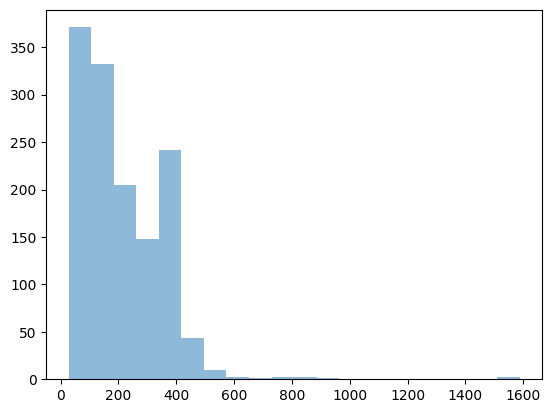

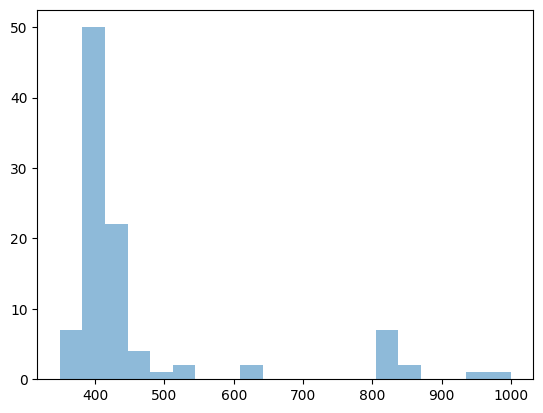

In [125]:
merged_sequence_lengths = [len(seq.seq) for seq in merged_sequences]
protein_sequence_lengths = [len(seq.seq) for seq in protein_sequences]

plt.hist(merged_sequence_lengths, bins=20, alpha=0.5, label='merged_sequence_lengths')
plt.show()
plt.hist(protein_sequence_lengths, bins=20, alpha=0.5, label='protein_sequence_lengths')
plt.show()

# SAVE FASTA

In [114]:
file_location = "merged_exon_sequences.txt"
SeqIO.write(merged_sequences, file_location, "fasta")

1361

### Please note that the sequences from BlastP are from different databases than WGS, hence they don't even have the same IDs, so not easy to compare them

# Just Checking two good sequences to see if they have some alignment

In [130]:
good_merged_seq = merged_sequences[30]
alignment = pairwise2.align.globalxx(good_merged_seq.seq, protein_sequences[0].seq)
print(format_alignment(*alignment[0]))


------KAGQ-LTIVGS-GIA-SINHMTLQAVAC---IETADV---VC-YV-VA-DG-ATEAFIRK--KNE-NCI-DLYPL-YSET----KE-R--TD-TYIQMAEVGA*FSCCILCEN*RVLCS*FMLNHVRAG---KN---VVGVFYGHPGVFVC-PT-HRAIY--IARN--EGYRAV-MLPGL-SAEDCLY-ADLG-IDPSTV--GCI-TYEAT-DM-LVYN-R--PLNS-S--SHLVLY-QVGI-VGK-ADFK-FAYDPKEVCVP-GFRFLVVCARLSRSAGW*-NHH--FGK-LI-DRLEL-EYGPD--HT-VVHYIAPIF---PTEE---PVMERFTIGQL-K-----LK-ENSDK--IATI------STFYL-PPKAPSA-KV-SLN----R--EFLRSLNI-A----DS---RDPMTPF--PW-N---PTAA--PYGEREKKVILELESHVPPPGYRPLKKNSGLA-QA----L------EK----L--SL----D--TR--AL---A-AW--KT-D-RKAY-AD-SVSG--LTDD--ER------D--A-----------L--A---SGKH--AQLS--GALK-------G--GWSS---
      |||  |||||  ||  ||..|||||      || |     |  |  |  |  ||||||    ||  ||  |||   |       |  |  |  |  ||       |     |    |    |   ||     |    |||||||||||||  |  |||    ||    |||||  ||||  ||||||  |||  ||||    ||  ||||  |  |    |  |    |  |||||  |||  ||  |||  |           |  |               |    ||  |  ||||  |||    |  ||||||      |      ||    |     |     |  |      ||        ||||  |||   | | 

In [81]:
whole_contig_sequence_iter = SeqIO.parse(whole_contig_sequences_file_name,"fasta")
aligned_sequence_iter = SeqIO.parse(aligned_wgs_sequences_file_name,"fasta")

sub_seq = next(aligned_sequence_iter)
whole_seq = next(whole_contig_sequence_iter)

protein_of_interest_sequence = Seq("""MESSTQTKPGSLIVVGTGIESIGQMTLQALSYIEAASKVFYCVIDPATEAFILTKNKNCVDLYQYYDNGKSRMDTYTQMAELMLKEVRNGLDVVGVFYGHPGVFVNPSHRALAIARSEGYQARMLPGVSAEDCLFADLCIDPSNPGCLTYEASDFLIRERPVNVHSHLILFQVGCVGIADFNFSGFDNSKFTILVDRLEQEYGPDHTVVHYIAAMMPHQDPVTDKFTIGQLREPEIAKRVGGVSTFYIPPKARKDINTDIIRLLEFLPAGKVPDKHTQIYPPNQWEPDVPTLPPYGQNEQAAITRLEAHAPPEEYQPLATSKAMTDVMTKLALDPKALAEYKADHRAFAQSVPDLTPQERAALELGDSWAIRCAMKNMPSSLLEAASQSVEEASMNGFPWVIVTGIVGVIGSVVSSA""")
#It would seem this sequence is slightly different to that of the papers sequence (the macrocycle sequence isn't the same)
macrocycle_sequence = Seq("WVIVTGIVGVIG")

In [8]:
def get_pos(sub_seq):#takes in a large sequence and returns the start and 
    #end positions of the subsequence in the bigger one
    position = sub_seq.id.split(":")[1]
    start_pos = 0
    end_pos = 0
    if("c" in position):
        start_pos = int(position.split("-")[0][1:])
        end_pos = int(position.split("-")[1])
    else:
        start_pos = int(position.split("-")[0])
        end_pos = int(position.split("-")[1])

    return (start_pos,end_pos)
    
print("location of subsequence",get_pos(sub_seq))
print(sub_seq.seq)
pos = get_pos(sub_seq)
size = abs(pos[0]-pos[1])
print(size, len(sub_seq.seq))
print(whole_seq.seq[18915-20*3:19937].reverse_complement())#I've added 30 bases

print(whole_seq.seq[18915-20*3:19937].reverse_complement().translate())
alignment = pairwise2.align.globalxx(whole_seq.seq[18915-20*3:19937].reverse_complement().translate(), protein_of_interest_sequence)
print(format_alignment(*alignment[0]))
chunked_sequence = whole_seq.seq[18915-20*3:19937].reverse_complement().translate()


location of subsequence (19937, 18915)
CTCATGCTCAAGGAAGTCCGCAATGGCCTCGACGTTGTCGGGGTATTCTATGGCCATCCGGGCGTGTTCGTGAACCCTTCTCACAGGGCATTGGCTATCGCCAGAAGCGAGGGATACCAAGCTCGTATGCTTCCAGGAGTATCTGCAGAGGACTGCCTCTTTGCCGACTTATGCATCGACCCCTCGAACCCCGGCTGCTTGACCTACGAAGCATCCGATTTCCTCATCAGAGAGAGACCAGTGAACGTTCACAGTCACCTCATTCTTTTCCAAGTTGGATGCGTCGGTATCGCAGACTTCAATTTCAGCGGATTCGACGTAAGGATTTTTCCATCCTGTAATGGTCGATCGATTTGTGTCTAACACGTTTAACTTTTCTTTTAGAATTCGAAATTTACCATTCTGGTTGACCGTCTCGAGCAAGAATACGGCCCAGACCATACCGTCGTGCATTATATCGCAGCTATGATGCCTCACCAAGATCCCGTCACCGACAAGTTCACGATCGGACAACTCCGTGAACCCGAAATCGCCAAACGAGTAGGTGGTGTTTCGACTTTTTACATCCCTCCAAAGGCCAGAAAGGATATCAACACCGATATCATCCGACTCTTGGAATTCCTACCTGCTGGTAAAGTTCCCGACAAACACACCCAAATCTACCCACCTAATCAATGGGAACCCGACGTGCCTACTCTACCTCCCTATGGACAAAACGAACAGGCTGCTATCACTAGATTGGAAGCTCACGCTCCCCCCGAAGAGTATCAGCCTCTGGCCACTTCCAAAGCTATGACTGACGTCATGACCAAACTAGCTTTGGATCCCAAGGCGCTCGCCGAGTATAAGGCTGATCATCGAGCCTTCGCTCAGTCTGTTCCTGACTTGACGCCTCAAGAGAGAGCAGCTTTGGAGCTAGGAGATTCATGGGCTATTCGGTGCGCCATGAAGAACATGCCGT

In [9]:
whole_seq = next(whole_contig_sequence_iter)

In [20]:
def get_subseqs_for_whole_seq(whole_seq):
    sequences = get_sequences(aligned_wgs_sequences_file_name)
    parsed_sequences = parse_ids(sequences)
    sequence_dict = create_seq_dict(parsed_sequences)
    id_of_interest = whole_seq.id.split(":")[0]
    #print(sequence_dict.items())
    return sequence_dict[id_of_interest]


sub_seq = get_subseqs_for_whole_seq(whole_seq)[0]
sub_seq.id = sub_seq.name
print(sub_seq.id)

pos = get_pos(sub_seq)
size = abs(pos[0]-pos[1])
print(pos)

print(sub_seq.seq)
print()
alignment = pairwise2.align.globalms(sub_seq.seq.translate(), protein_of_interest_sequence,2,-1,-5,-0.1)#gap penalty of -5 seems to work well at preventing them from forming!
print(format_alignment(*alignment[0]))
print()

chopped_whole_seq = whole_seq[pos[0]-1:]
translated_whole_seq = chopped_whole_seq.translate()
print("extended whole seq")
print(translated_whole_seq.seq[:510])
print()
print("Whole allignement",len(translated_whole_seq.seq))
alignment = pairwise2.align.globalms(translated_whole_seq.seq[:500], protein_of_interest_sequence,2,-1,-5,-0.1)
print(format_alignment(*alignment[0]))
#print(whole_seq.id)
#print(chopped_whole_seq.seq)

RCHF01001239.1:4082-5398
(4082, 5398)
ATGGAATCTTCTGCTCAACCCAAAGCTGGATCGCTCACCATCGTCGGTACAGGTATCGAGAGCATCGGTCAGATGACGCTCCAGGCCTTATCGTACATCGAAGCCGCATCCAAAGTCTTCTACTGCGTCATCGACCCTGCGACTGAGGCTTTCATCCTCACTAAGAACAAGGACTGTGTCGACTTGTATCAGTACTATGATAACGGCAAATCCAGAATGGATACCTATACCCAAATGGCCGAGGTATGAAGCGCCCACCTTTAATTCCGTTCCAGGGACTCGCGCTGATGTATCTGTAGCTCATGCTTAGGGAAGTTCGAAACGGTCTCGATGTTGTTGGGGTATTCTATGGCCACCCAGGCGTGTTCGTGAACCCTTCGCACCGAGCACTATCGATCGCCAGAAGCGAGGGATACCGAGCACGTATGTTGCCAGGAGTGTCTGCCGAGGACTGTCTCTTTGCCGACTTGTGCATTGATCCCTCGAACCCCGGCTGCCTGACCTACGAGGCATCCGATTTCCTCATCAGGGAAAGGCCAGTGAACATTCACAGTCACTTGGTTCTCTTCCAAGTCGGATGTGTCGGTATTGCGGACTTTAACTTTAGCGGATTCGACGTAAGTATATCACCCGACTATCGTACAAGTATTTTCATCTAATAATCTTACCTGTGCAAAGAACTCGAAATTCAACGTGTTGGTTGAACGCCTCGAGCAGGAGTACGGGCCAGACCATACCGTCGTGCACTACATTGCCGCCATGATGCCTCACCAGGATCCTGTCACCGACAAATTCACGATCGGGCAGCTGCGCGAACCTGAAATTGCGAAGCGCGTAGGCGGTGTTTCGACTTTCTACATCCCCCCGAAGGCCAGAAAGGACATCAACACCGACATCATTCGTCTCCTAGAGTTCTTGCCTGCCGGGAAAGTTCCCGACAAACACACTCAGATCTACCCGCC

In [113]:
whole_seq = next(whole_contig_sequence_iter)
sub_seq = get_subseqs_for_whole_seq(whole_seq)[0]
sub_seq.id = sub_seq.name

In [116]:
#patterns that I tend to see:
#the W tends to be 12 aa before the stop codon

#VM(maybe L) tend to appear after stop codons, potentially something to do with splicing

def print_alignment(seq1,seq2):
    alignment = pairwise2.align.globalms(seq1, seq2,2,-1,-5,-0.1)#gap penalty of -5 seems to work well at preventing them from forming!
    print(format_alignment(*alignment[0]))
    
def get_protein_sequence_till_termination(sub_seq,whole_seq,POI_seq):
    sub_seq.id = sub_seq.name
    print("Working on Seq,\n",sub_seq.id)
    pos = get_pos(sub_seq)
    size = abs(pos[0]-pos[1])
    print("Sequence pos,\n", pos)
    if(pos[0]<pos[1]):
        print("sequence is in correct frame")
        print("\nAlignment of Sub Sequence with POI")
        print_alignment(sub_seq.seq.translate(), protein_of_interest_sequence)
        print()
        chopped_whole_seq = whole_seq[pos[0]-1:]
        translated_whole_seq = copy.deepcopy(chopped_whole_seq)
        translated_whole_seq.seq = chopped_whole_seq[:size+1+1500].seq.translate()
        print("\nTranslated Whole_Seq:\n{}".format(translated_whole_seq.seq))
        stop_codon_pos = translated_whole_seq.seq.find("*",int((size+1)/3))
        stop_codon_positions = [index for index, char in enumerate(translated_whole_seq.seq) if char == '*' and index>int((size+1)/3)]
        print("Stop Codon Position")
        #print(stop_codon_positions)
        if(stop_codon_pos != -1):
            print("whole Sequence has a stop codon!")
            result = []
            #translated_whole_seq = translated_whole_seq[:stop_codon_pos]
            for stop_pos in stop_codon_positions:
                result.append(translated_whole_seq[:stop_pos])
                #print("\nAlignment of Protein Sequence with POI")
                #print(translated_whole_seq.seq[:stop_pos],"\n")
                #if("W" in translated_whole_seq.seq[:stop_pos][-15:]):
                #    print("W IN THE LAST PART OF THE SEQUENCE")
                #    print_alignment(translated_whole_seq.seq[:stop_pos], protein_of_interest_sequence)
                #print()
            return result
        else:
            print("ERROR, whole sequence didn't have a stop codon!")
            return []
    else:
        print("Cannot deal with reverse frame sequences just yet")
        return []

results = get_protein_sequence_till_termination(sub_seq,whole_seq,protein_of_interest_sequence)
#print([str(seq.seq) for seq in results if "W" in seq.seq[-20:]])

def get_true_result(sequences):
    for seq in sequences:
        if("W" in seq.seq[-20:]):
            print("Got a speedy W")
            print(seq.seq)
            return seq

get_true_result(results)

Working on Seq,
 VYXO01000008.1:637598-638710
Sequence pos,
 (637598, 638710)
sequence is in correct frame

Alignment of Sub Sequence with POI
-------RPGKLVIVGSGIRSISQFTLEAVAHIEHADKVFYCVADPGTDAFIERHNKNAVDLYNLYDDGKPRNQTYTQMAETILREVRKGFYVVGVFYGHPGVFVNPSHRAARIAIREGYDATMLPGVSAEDCLYADLLIDPSRPGCQTLEATDVLLRKRPIAKDCHVIIFQVGAVGDLGFNFKGFKNTKFQVLVRRLWEIYGPDHTVVHYVASQLTFASPIKDRLTIKDLEKPQVAKSITGISTFYLPPK-------------------------------------VLLQPDEAVAKSLGLITRPTTSASFGPFPIDEPYGPREIAAVKALDSHKQPVNYNKTRASPAMYQALESLALNPKEVSKFRSSREKFIARIDG------------------LTKSEEKALRYGSTGLIRLALK---SSVDEIATQFV--------------------------Q
       .||.|..||.||.||.|.||.|...||.|.||||||.||.|.|||...|||.||||..||.||.|..|||||||..|.|||.|..|||||||||||||||||||..||..|||.|.|||||||||||.|||.||||.|||.|.||.|.|.|.||.....|.|.||||.||...|||.||.|.||..||.||...||||||||||.|.......|..|..||..|..|..||...|.||||.|||                                     |                           |...|||..|.||...|..|..|..|.....|.||......|||.||                               

In [21]:
import time
import datasets
from datasets import Dataset, load_dataset

def slow_fn(sample):
    print(f'starting proc')
    time.sleep(2)
    sample['hash '] = len(sample['seq'])
    print(f'finishing proc')
    return sample

data = [{'seq':'abcd'}]*40

In [22]:
seq_dataset = Dataset.from_list(data)

In [25]:
new_seq_dataset = seq_dataset.map(slow_fn, num_proc=100)

num_proc must be <= 40. Reducing num_proc to 40 for dataset of size 40.
#0:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc



#1:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc




#2:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc


starting proc

#3:   0%|          | 0/1 [00:00<?, ?ex/s]





#4:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc







#5:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc


starting proc

#6:   0%|          | 0/1 [00:00<?, ?ex/s]








#7:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc










#8:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc











#9:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc












#10:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc













#11:   0%|          | 0/1 [00:00<?, ?ex/s]


starting proc













#12:   0%|          | 0/1 [00:00<?, ?ex/s]


starting proc














#13:   0%|          | 0/1 [00:00<?, ?ex/s]


starting proc

#14:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc
















#15:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc


















#16:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc



















#17:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc




















#18:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc





















 ... (more hidden) ...


starting procstarting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
finishing proc


#0: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc



#1: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc




#2: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc





#3: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc






#4: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc







#5: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc








#6: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc









#7: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc










#8: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc











#9: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc












#10: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc













#11: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc














#12: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc















#13: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc
















#14: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc

















#15: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


















#16: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc



















#17: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc




















#18: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc





















#19: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex][A


finishing proc


#20: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#21: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#22: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#23: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#24: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#27: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#25: 100%|██████████| 1/1 [00:02<00:00,  2.04s/ex]


finishing proc


#28: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#26: 100%|██████████| 1/1 [00:02<00:00,  2.05s/ex]


finishing proc


#29: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#30: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#31: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#32: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#33: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#34: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#35: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#36: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#37: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#38: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#39: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]
